In [59]:
import numpy as np
import math
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import confusion_matrix

In [58]:
filter_size1 = 5
num_filters1 = 16

filter_size2 = 5
num_filters2 = 36

fc_size = 128

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
data.test.cls = np.argmax(data.test.labels, axis=1)

img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size, img_size)
num_classes = 10
num_channels = 1

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

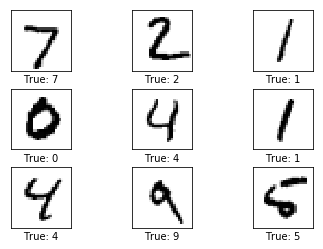

In [5]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

In [6]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.5))

def new_biases(length):
    return tf.Variable(tf.constant(0.5, shape=[length]))

In [7]:
def new_conv_layer(input,
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling=True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1,1,1,1],
                        padding='SAME')
    layer = layer+biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

In [8]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [9]:
def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [10]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [11]:
layer_conv1, weights_conv1 = new_conv_layer(x_image, num_channels, filter_size1, num_filters1, True)
print(layer_conv1)
layer_conv2, weights_conv2 = new_conv_layer(layer_conv1, num_filters1, filter_size2, num_filters2, True)
print(layer_conv2)
layer_flat, num_features = flatten_layer(layer_conv2)
print(layer_flat)
layer_fc1 = new_fc_layer(layer_flat, num_features, fc_size, True)
print(layer_fc1)
layer_fc2 = new_fc_layer(layer_fc1, fc_size, num_classes, False)
print(layer_fc2)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

Tensor("Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("Relu_1:0", shape=(?, 7, 7, 36), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 1764), dtype=float32)
Tensor("Relu_2:0", shape=(?, 128), dtype=float32)
Tensor("add_3:0", shape=(?, 10), dtype=float32)


In [23]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations, total_iterations+num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict = feed_dict_train)
        if i%100 == 0:
            acc = session.run(accuracy, feed_dict = feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
    total_iterations += num_iterations
    end_time = time.time()
    time_diff = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

In [25]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]

    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [26]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

In [27]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [28]:
print_test_accuracy()

Accuracy on Test-Set: 12.0% (1199 / 10000)


In [29]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   7.8%
Time usage: 0:00:00


In [30]:
print_test_accuracy()

Accuracy on Test-Set: 12.2% (1216 / 10000)


Time usage: 0:00:10
Accuracy on Test-Set: 26.1% (2605 / 10000)
Example errors:


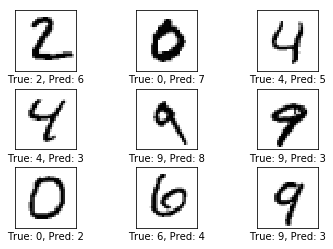

In [31]:
optimize(num_iterations=99)
print_test_accuracy(show_example_errors=True)

Optimization Iteration:    101, Training Accuracy:  23.4%
Optimization Iteration:    201, Training Accuracy:  39.1%
Optimization Iteration:    301, Training Accuracy:  39.1%
Optimization Iteration:    401, Training Accuracy:  67.2%
Optimization Iteration:    501, Training Accuracy:  60.9%
Optimization Iteration:    601, Training Accuracy:  62.5%
Optimization Iteration:    701, Training Accuracy:  71.9%
Optimization Iteration:    801, Training Accuracy:  67.2%
Optimization Iteration:    901, Training Accuracy:  81.2%
Time usage: 0:01:39
Accuracy on Test-Set: 74.8% (7481 / 10000)
Example errors:


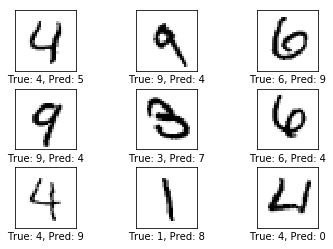

In [32]:
optimize(num_iterations=900)
print_test_accuracy(show_example_errors=True)

Optimization Iteration:   1001, Training Accuracy:  89.1%
Optimization Iteration:   1101, Training Accuracy:  81.2%
Optimization Iteration:   1201, Training Accuracy:  76.6%
Optimization Iteration:   1301, Training Accuracy:  84.4%
Optimization Iteration:   1401, Training Accuracy:  76.6%
Optimization Iteration:   1501, Training Accuracy:  79.7%
Optimization Iteration:   1601, Training Accuracy:  90.6%
Optimization Iteration:   1701, Training Accuracy:  78.1%
Optimization Iteration:   1801, Training Accuracy:  84.4%
Optimization Iteration:   1901, Training Accuracy:  89.1%
Optimization Iteration:   2001, Training Accuracy:  73.4%
Optimization Iteration:   2101, Training Accuracy:  75.0%
Optimization Iteration:   2201, Training Accuracy:  82.8%
Optimization Iteration:   2301, Training Accuracy:  87.5%
Optimization Iteration:   2401, Training Accuracy:  89.1%
Optimization Iteration:   2501, Training Accuracy:  89.1%
Optimization Iteration:   2601, Training Accuracy:  81.2%
Optimization I

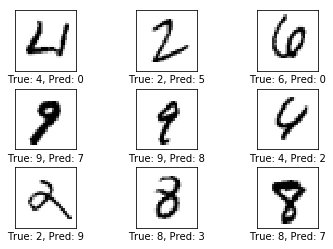

In [33]:
optimize(num_iterations=9000)
print_test_accuracy(show_example_errors=True)

Accuracy on Test-Set: 94.1% (9411 / 10000)
Example errors:


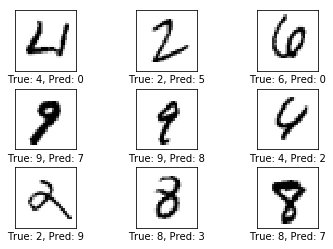

Confusion Matrix:
[[ 943    0   11    1    0    5    9    2    6    3]
 [   0 1115    6    0    1    4    1    2    5    1]
 [   7    6  970   24    1    2    3    8    9    2]
 [   3    1    9  960    0   23    0    5    5    4]
 [   4    5    4    1  927    1    9    7    6   18]
 [   9    1    2   25    4  831   11    1    6    2]
 [   9    3    2    1   11   10  910    0   11    1]
 [   1    2   25   11    5    2    0  962    3   17]
 [  10    3   17   23    4   12    6   10  877   12]
 [   5    8    2   12   26    9    2   18   11  916]]


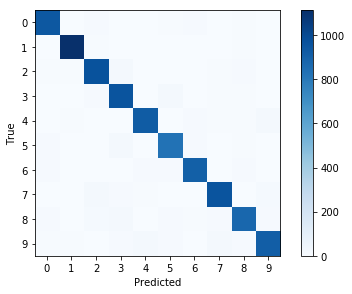

In [34]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [35]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))

    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [36]:
def plot_conv_layer(layer, image):
    feed_dict = {x: [image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):

        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [37]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')
    plt.show()

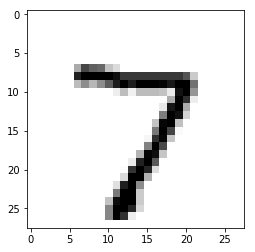

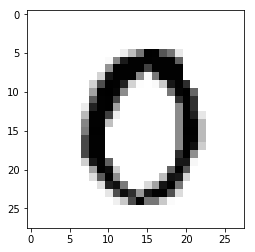

In [38]:
image1 = data.test.images[0]
plot_image(image1)
image2 = data.test.images[13]
plot_image(image2)

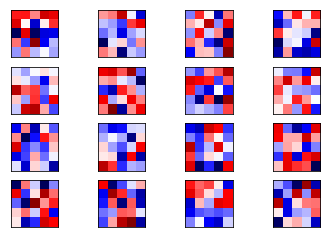

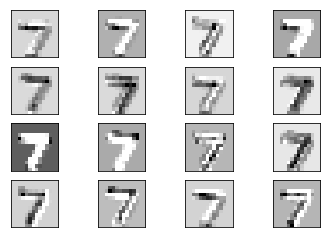

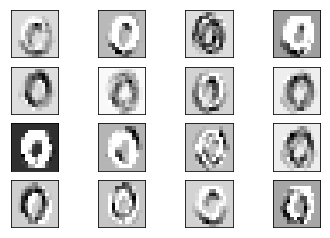

In [39]:
plot_conv_weights(weights=weights_conv1)
plot_conv_layer(layer=layer_conv1, image=image1)
plot_conv_layer(layer=layer_conv1, image=image2)

### 1. Create your own convolutional network

In [43]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10
num_channels = 1

filter_size1 = 5
num_filters1 = 16
filter_size = 5
num_filters2 = 32
fc_size = 64

learning_rate = 0.001
batch_size = 64
num_iterations = 5000

In [44]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [49]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.5))

def new_biases(length):
    return tf.Variable(tf.truncated_normal([length], stddev=0.5))

def new_conv_layer(input,
                  num_input_channels,
                  num_filters,
                  filter_size,
                  use_pooling=True):
    filter_shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(filter_shape)
    biases = new_biases(num_filters)
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1,1,1,1],
                        padding='SAME')
    layer = layer+biases
    layer = tf.nn.relu(layer)
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [52]:
conv_layer1, conv1_weights = new_conv_layer(x_image, num_channels, num_filters1, filter_size1, True)
print(conv_layer1)
conv_layer2, conv2_weights = new_conv_layer(conv_layer1, num_filters1, num_filters2, filter_size2, True)
print(conv_layer2)
flat_layer, num_features = flatten_layer(conv_layer2)
print(flat_layer)
fc_layer1 = new_fc_layer(flat_layer, num_features, fc_size, True)
print(fc_layer1)
fc_layer2 = new_fc_layer(fc_layer1, fc_size, num_classes, False)
print(fc_layer2)

Tensor("MaxPool_5:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("MaxPool_6:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("Reshape_3:0", shape=(?, 1568), dtype=float32)
Tensor("Relu_8:0", shape=(?, 64), dtype=float32)
Tensor("add_10:0", shape=(?, 10), dtype=float32)


In [54]:
y_pred = tf.nn.softmax(fc_layer2)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc_layer2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [55]:
correct_prediction=tf.equal(y_pred_cls, y_true_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [57]:
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        sess.run(optimizer, feed_dict=feed_dict_train)
    feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}
    acc = sess.run(accuracy, feed_dict = feed_dict_test)
    print("Accuracy on test set is: {0:.1%}".format(acc))

Accuracy on test set is: 96.5%
